In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalIsingModel


from regain import utils; reload(utils);


# ISING

In [2]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
#import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=5,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [448]:
import networkx as nx

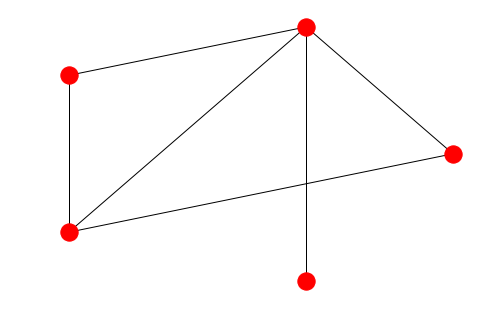

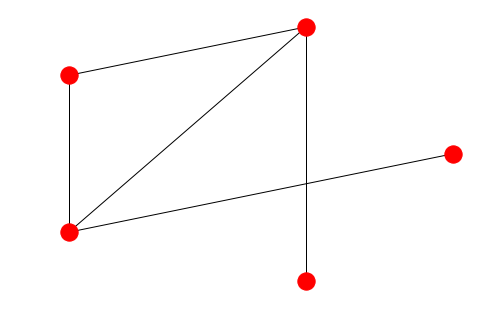

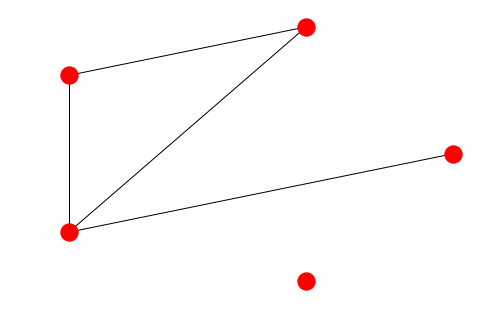

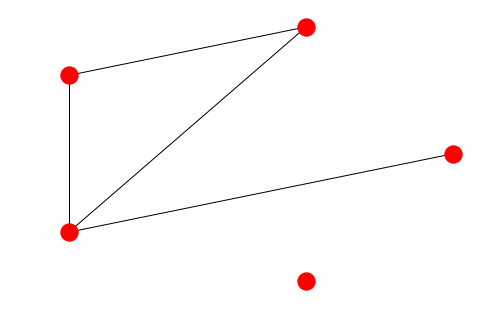

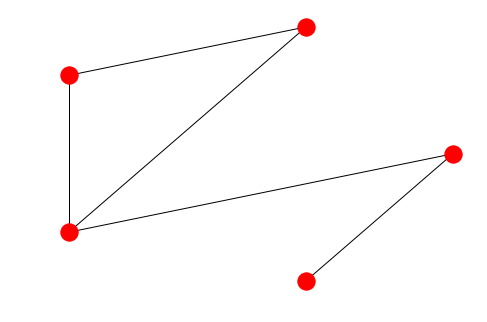

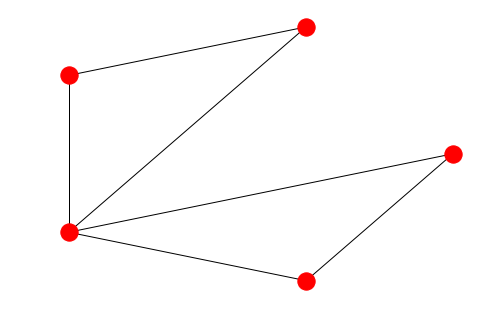

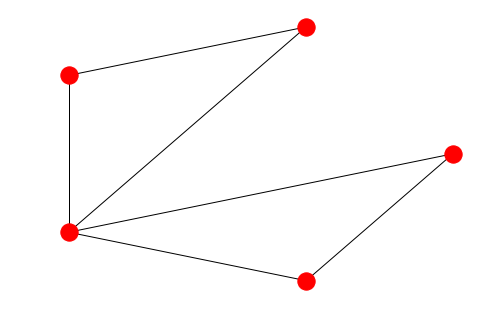

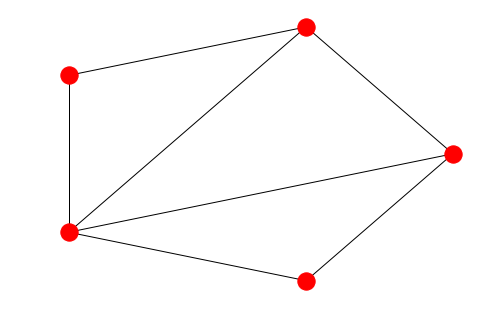

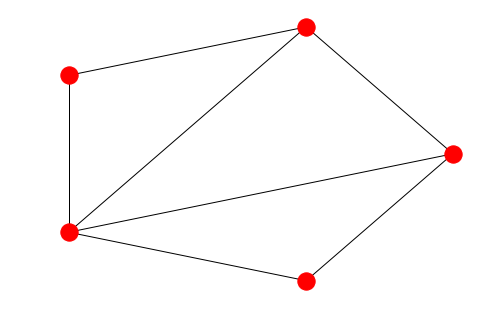

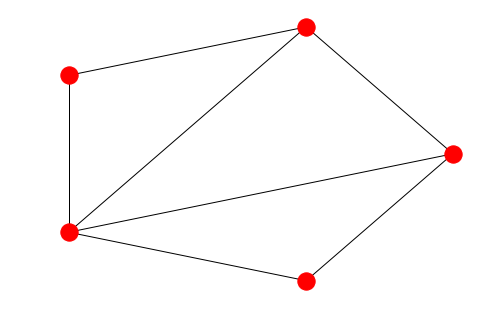

In [449]:
for t in thetas:
    g = nx.from_numpy_array(t)
    nx.draw_circular(g)
    plt.show()

In [3]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

In [ ]:
ising_mdl = Ising_GLM_GM(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)

In [471]:
np.mean(params)

0.4395918367346939

In [459]:
precisions = []
for e in estimators:
    precisions.append(e.precision_)
# ising_mdl = Ising_GLM_GM(alpha=np.mean(params), mode='symmetric_fbs', verbose=0)
# ising_mdl.fit(samples[0])
# utils.structure_error(np.array(thetas[0]), np.array(ising_mdl.precision_), no_diagonal=True)

In [460]:
ising_mdl.get_params()

{'alpha': 0.32,
 'compute_objective': True,
 'max_iter': 100,
 'mode': 'symmetric_fbs',
 'reconstruction': 'union',
 'return_history': True,
 'return_n_iter': False,
 'rho': 1,
 'rtol': 0.0001,
 'tol': 0.0001,
 'verbose': 0}

In [461]:
utils.structure_error(np.array(thetas), np.array(precisions), no_diagonal=True)

{'tp': 36,
 'tn': 86,
 'fp': 0,
 'fn': 78,
 'precision': 1.0,
 'recall': 0.3157894736842105,
 'f1': 0.4799999999999999,
 'accuracy': 0.488,
 'false_omission_rate': 0.47560975609756095,
 'fdr': 0.0,
 'npv': 0.524390243902439,
 'prevalence': 0.456,
 'miss_rate': 0.6842105263157895,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 0.6842105263157895,
 'dor': 0.0,
 'balanced_accuracy': 0.6578947368421053,
 'average_precision': 0.4601408972932888}

In [405]:
import pickle as pkl

In [409]:
with open("../../../../projects/time_exponential_family/results_ising/results_single.pkl", "wb") as f:
    pkl.dump([precisions, params], f)


In [ ]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                      sampling_size=800, plot=True, 
                                      n_repetitions=20)
cv.fit(X, y)

In [468]:


from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=10)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params), psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernel,  init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [469]:
mdl.fit(X, y)
utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)

{'tp': 40,
 'tn': 86,
 'fp': 0,
 'fn': 74,
 'precision': 1.0,
 'recall': 0.3508771929824561,
 'f1': 0.5194805194805194,
 'accuracy': 0.504,
 'false_omission_rate': 0.4625,
 'fdr': 0.0,
 'npv': 0.5375,
 'prevalence': 0.456,
 'miss_rate': 0.6491228070175439,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 0.6491228070175439,
 'dor': 0.0,
 'balanced_accuracy': 0.6754385964912281,
 'average_precision': 0.48424606151537863}

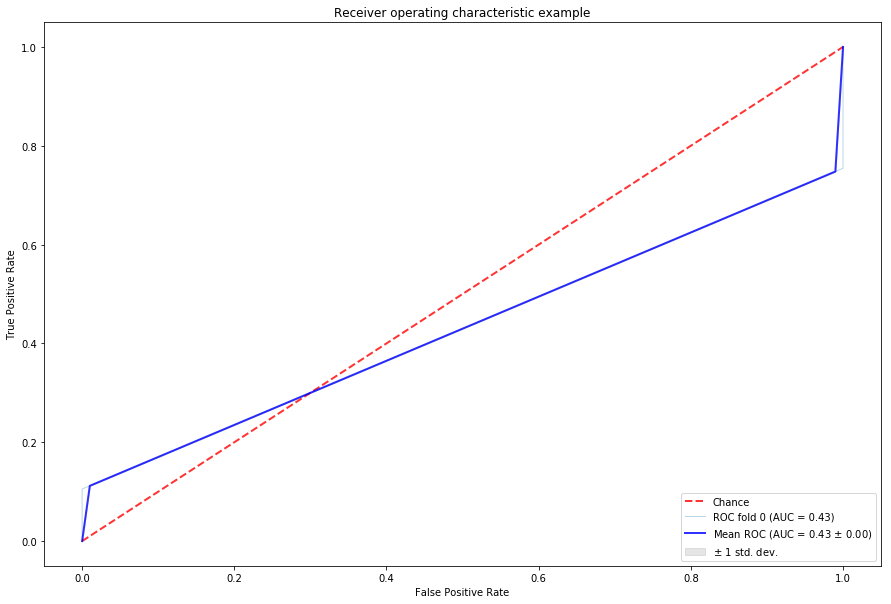

In [470]:
from regain.plotting.results import plot_roc_curves

plot_roc_curves(np.array(thetas), [mdl.precision_])

ValueError: multilabel-indicator format is not supported

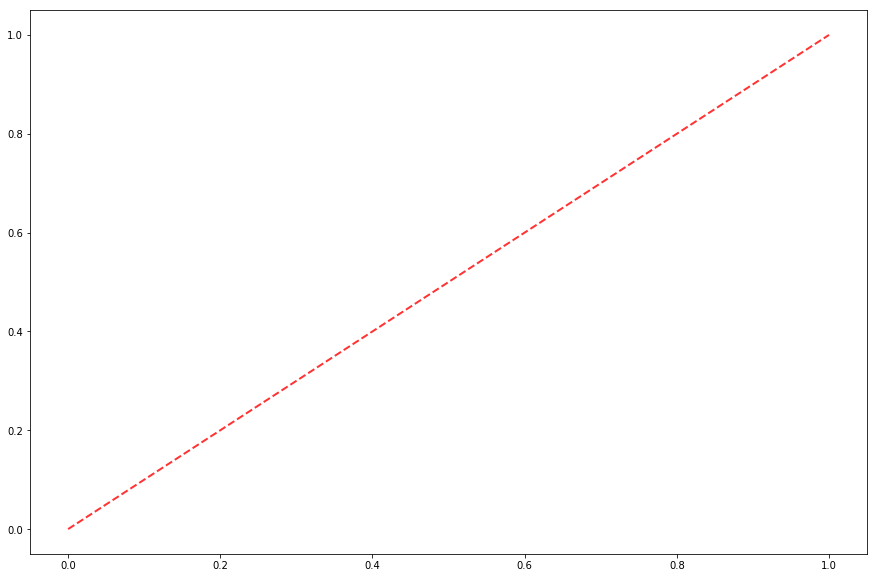

In [430]:
plot_roc_curves(thetas[0], [precisions[0]])

In [431]:
precisions

[array([[ 0.        , -0.        , -0.0090137 ,  0.37097223, -0.71071443],
        [-0.        ,  0.        ,  0.        , -0.        ,  0.        ],
        [-0.0090137 ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.37097223, -0.        ,  0.        ,  0.        , -0.56853452],
        [-0.71071443,  0.        ,  0.        , -0.56853452,  0.        ]]),
 array([[ 0.        ,  0.29308068, -0.        ,  0.        , -0.23711188],
        [ 0.29308068,  0.        , -0.        ,  0.        , -0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ],
        [-0.23711188, -0.        ,  0.        , -0.        ,  0.        ]]),
 array([[ 0.        ,  0.        , -0.44753888, -0.        , -0.        ],
        [ 0.        ,  0.        , -0.        , -0.27764597,  0.        ],
        [-0.44753888, -0.        ,  0.        ,  0.27192945,  0.        ],
        [-0.        ,

In [432]:
mdl.precision_

array([[[ 0.        , -0.        , -0.        ,  0.18615804,
         -0.39834527],
        [-0.        ,  0.        ,  0.        , -0.        ,
          0.        ],
        [-0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.18615804, -0.        ,  0.        ,  0.        ,
         -0.30546931],
        [-0.39834527,  0.        ,  0.        , -0.30546931,
          0.        ]],

       [[ 0.        ,  0.29534832, -0.        ,  0.        ,
         -0.23938478],
        [ 0.29534832,  0.        , -0.        ,  0.        ,
         -0.        ],
        [-0.        , -0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
         -0.        ],
        [-0.23938478, -0.        ,  0.        , -0.        ,
          0.        ]],

       [[ 0.        ,  0.        , -0.42255345, -0.        ,
         -0.        ],
        [ 0.        ,  0.        , -0.        , -0.2565824 ,
          0